# Base model

In this notebook the base model with constant production rate in growth and starvation phases is discussed. In this model we allow the limitation of glucose uptake and therefor accumulation of glucose in the medium.

In [1]:
import scripts.model_feed_starvation as model
import scripts.plot_results as plot_results
import os
import pickle
import collections
import numpy as np
import pandas as pd
import scipy.optimize


In [2]:
# load model parameter
dir = "plots/model_feed_starvation/"
if not os.path.exists(dir):
    os.makedirs(dir)

with open("data/basic_parameters.p", "rb") as file:
    parameter = pickle.load(file)

Dfs = collections.namedtuple("Dfs", "all, growth, lin")
with open("data/flows.p", "rb") as file:
    dfs = pickle.load(file)


In [3]:
# fit for base model
res_growth = dfs.lin[dfs.lin.starvation == "growth"]


def fit_r(t, r):
    mod = model.Model(**parameter, qP_growth=r, phase_profile=[("growth", t)])
    X, P = mod.calc_X_P_end()
    return P


f = np.vectorize(fit_r)

r, cov = scipy.optimize.curve_fit(
    f=f, xdata=res_growth.t.values, ydata=res_growth.P.values, p0=[1e-2]
)
qP_growth = r[0]
qP_growth


0.0026643109762657835

In [4]:
# estimate qP_starv
df_starv = dfs.all[dfs.all.starvation == "starvation"].copy()
qP_starvation = df_starv.qP.mean()
qP_starvation


0.0019681655097198237

In [5]:
# compare qP_growth for the same interval
dfs.growth["r"] = dfs.growth.dP / dfs.growth.dt / dfs.growth.X_av
qP_growth2 = dfs.growth[dfs.growth.index > 23].r.mean()
qP_growth2


0.0010597562468631688

In [6]:
starvation_prifile = [("growth", 23), ("starvation", 35)]

model_lin = model.Model(**parameter, qP_growth=qP_growth, qP_starvation=qP_starvation)
model_lin_starv = model.Model(
    phase_profile=starvation_prifile,
    **parameter,
    qP_growth=qP_growth,
    qP_starvation=qP_starvation
)
model_exp = model.Model(
    qf=model.exp_feed_rate,
    **parameter,
    qP_growth=qP_growth,
    qP_starvation=qP_starvation
)
model_exp_starv = model.Model(
    phase_profile=starvation_prifile,
    qf=model.exp_feed_rate,
    **parameter,
    qP_growth=qP_growth,
    qP_starvation=qP_starvation
)
model_lin.calc()
model_lin_starv.calc()
model_exp.calc()
model_exp_starv.calc()


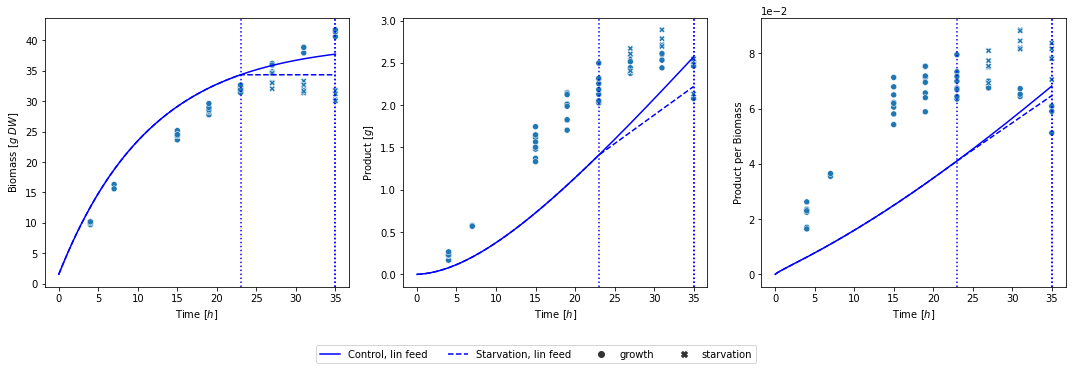

In [7]:
plot_results.plot_with_data(
    model_lin,
    model_lin_starv,
    "Control, lin feed",
    "Starvation, lin feed",
    colors=["b", "b"],
    style=["-", "--"],
    filename="plots/model_feed_starvation/model_feed_starvation_compare.png",
    show_data="lin",
)


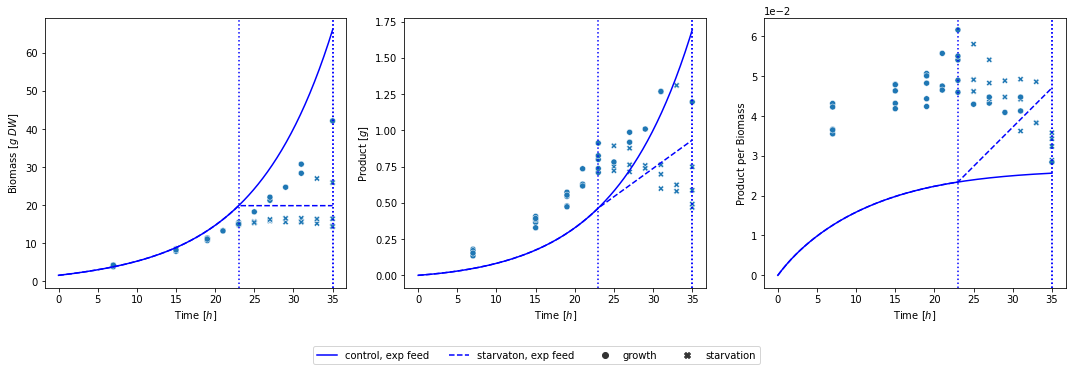

In [8]:
plot_results.plot_with_data(
    model_exp,
    model_exp_starv,
    "control, exp feed",
    "starvaton, exp feed",
    colors=["b", "b"],
    style=["-", "--"],
    filename="plots/model_feed_starvation/model_feed_starvation_compare_exp.png",
    show_data="exp",
)

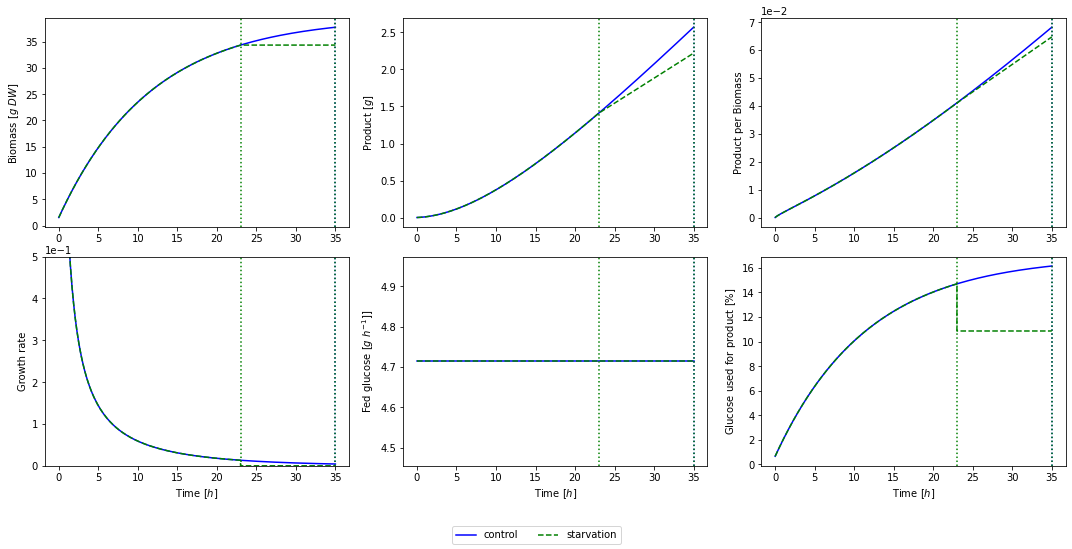

In [9]:
plot_results.plot_results(
    model_lin,
    model_lin_starv,
    "control",
    "starvation",
    filename="plots/model_feed_starvation/compare_lin.png",
)


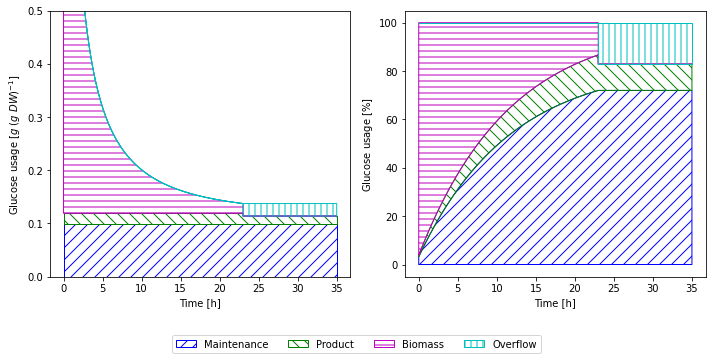

In [10]:
plot_results.energy_usage(model_lin_starv, filename='plots/model_feed_starvation/lin_glucose_usage.png')

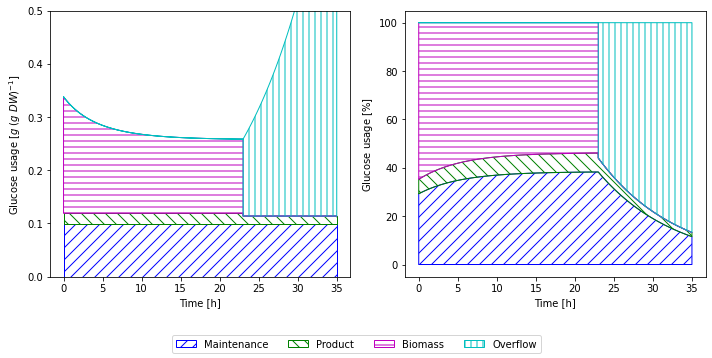

In [11]:
plot_results.energy_usage(model_exp_starv, filename='plots/model_feed_starvation/exp_glucose_usage.png')